# 1. Import Ntuple

In [31]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import plotly.express as px
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Generic MC15ri Ntuple locations
columns += ['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']
sig_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/*.root:B0'],
                          library="np",
                          cut='(mode>=5) & (mode<=15)',
                          filter_branch=lambda branch: branch.name in columns)
fakeD_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/*.root:B0'],
                          library="np",
                          cut='mode==0',
                          filter_branch=lambda branch: branch.name in columns)
fakeB_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/BBbar_signal_region/*.root:B0'],
                          library="np",
                          cut='(mode>=2) & (mode<=4)',
                          filter_branch=lambda branch: branch.name in columns)

# conti_mc15ri = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/continuum/MC15ri_continuum_1ab_e_2/*.root:B0'],
#                           library="np",
#                           #cut=sig_input_cut,
#                           filter_branch=lambda branch: branch.name in columns)

df_sig = pd.DataFrame(sig_mc15ri)
df_fakeD = pd.DataFrame(fakeD_mc15ri)
df_fakeB = pd.DataFrame(fakeB_mc15ri)
# df_conti = pd.DataFrame(conti_mc15ri)

In [ ]:
samples=util.get_dataframe_samples_new(df_sig, 'e', template=False)
for name, df in samples.items():
    print(name, len(df))

In [32]:
# Generic MC15ri Ntuple locations
columns += ['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']
sig_region = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_1ab_persian_e_1/AfterBDTcut/*.root:B0'],
                          library="np",
#                           cut='(mode>=5) & (mode<=15)',
                          filter_branch=lambda branch: branch.name in columns)


df_sig_region = pd.DataFrame(sig_region)
samples=util.get_dataframe_samples_new(df_sig_region, 'e', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 83863
bkg_TDFl 4217
bkg_fakeTracks 2418
bkg_continuum 7061
bkg_combinatorial 11508
bkg_singleBbkg 6419
bkg_other_TDTl 0
$D\tau\nu$ 4952
$D^\ast\tau\nu$ 2561
$D\ell\nu$ 69355
$D^\ast\ell\nu$ 45603
$D^{\ast\ast}\tau\nu$ 1463
$D^{\ast\ast}\ell\nu$ 26858
$D\ell\nu$_gap 5546
bkg_other_signal 0


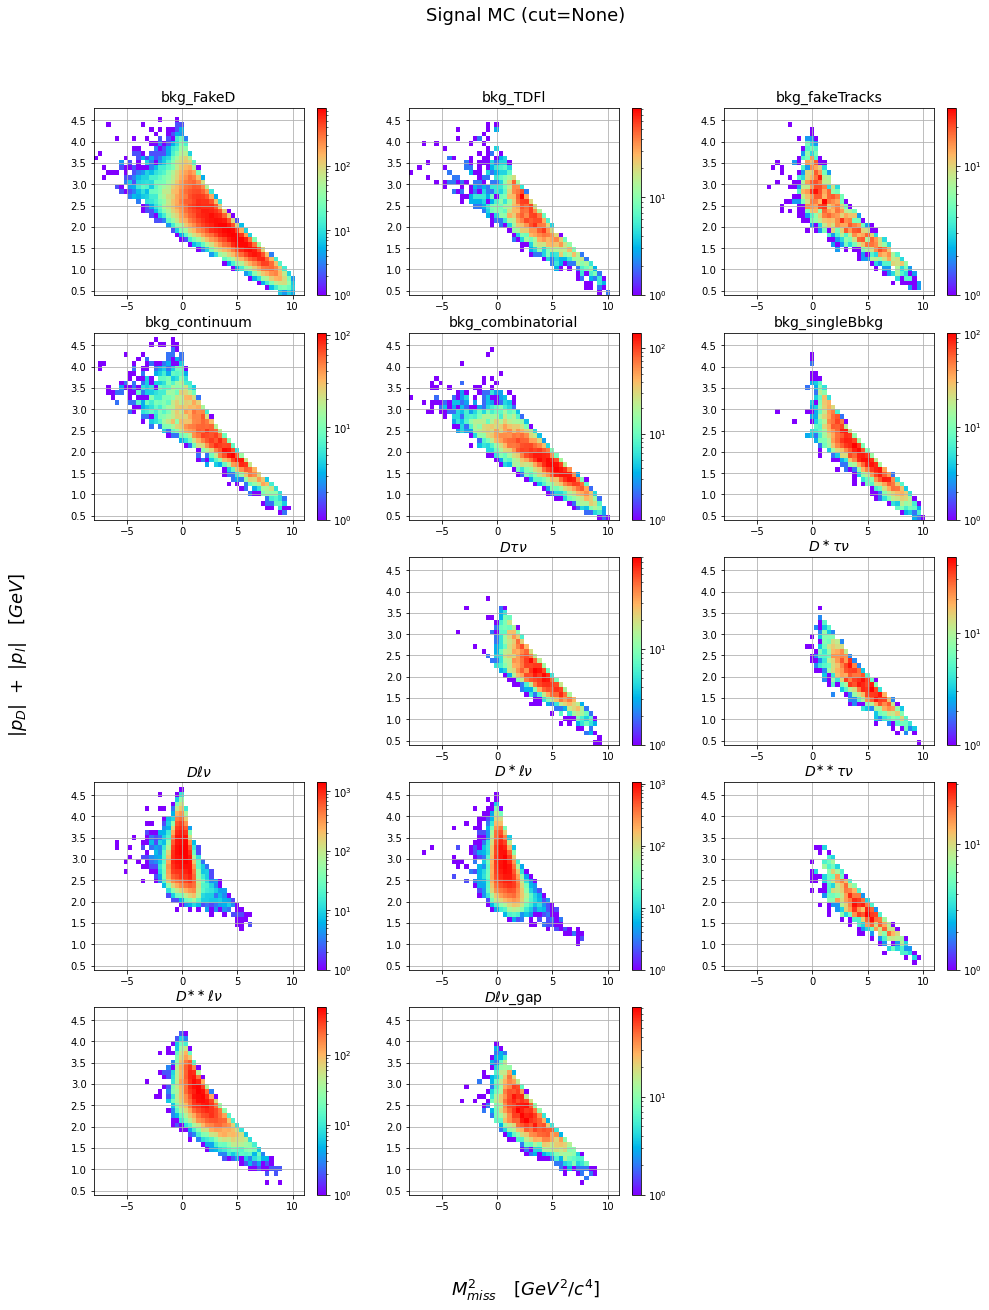

In [7]:
mpl.plot_hist_2d(mask=None)

In [25]:
samples[r'$D^{\ast\ast}\ell\nu$_gap_non'][['B0_mcPDG','B0_mcErrors']].value_counts()

B0_mcPDG  B0_mcErrors
 511.0    24.0           3315
-511.0    24.0           3289
          1048.0         1904
 511.0    1048.0         1896
-521.0    296.0          1488
                         ... 
-511.0    3244.0            1
          3256.0            1
 511.0    3244.0            1
          184.0             1
-511.0    3260.0            1
Length: 89, dtype: int64

In [38]:
# load MVA
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../../BDTs/LightGBM/lgbm_multiclass.txt')
cut='signal_prob==largest_prob and signal_prob>0.8 and D_daughter_pValue_min>D_daughter_pValue_mean/100'

In [39]:
df_conti.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_conti.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)
df_conti['D_daughter_pValue_min'] = df_conti[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].min(axis=1)
df_conti['D_daughter_pValue_mean'] = df_conti[['D_K_pValue','D_pi1_pValue','D_pi2_pValue']].mean(axis=1)

In [40]:
pred_conti = bst_lgb.predict(df_conti[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out_conti = pd.DataFrame(pred_conti, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb_conti = pd.concat([df_conti, lgb_out_conti], axis=1)
df_lgb_conti['largest_prob'] = df_lgb_conti[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred_conti, df_conti, lgb_out_conti

df_cut_conti=df_lgb_conti.query(cut)
df_bestSelected_conti=df_cut_conti.loc[df_cut_conti.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df_conti = df_bestSelected_conti

In [3]:
def statistics(df):
    counts=df.count()
    mean=df.mean()
    std=df.std()
    return f'''{counts=:d} \n{mean=:.3f} \n{std=:.3f}'''

def plot_fakeB_overlaid(variable,bins,cut=None,scale=[1,1]):

    df_sig['__weight__'] = scale[0]
    df_fakeB['__weight__'] = scale[1]

    fig,axs =plt.subplots(sharex=True, sharey=False,figsize=(10, 6))
    dfs = [df_sig, df_fakeB.query('B0_mcErrors==512')]
    names = [r'$D\tau\nu$_3ab','fake T']
    for i in range(len(names)):
        var_col = dfs[i].query(cut)[variable] if cut else dfs[i][variable]
        (counts, _) = np.histogram(var_col, bins=bins,
                                   weights=dfs[i].query(cut)['__weight__'] if cut else dfs[i]['__weight__'])
        kwarg={'histtype':'step','lw':2}

        axs.hist(bins[:-1], bins, weights=counts,
                label=f'{names[i]} \n{statistics(var_col)}',**kwarg)

    axs.set_title(f'Overlaid signal and fakeT ({cut=})')
    axs.set_xlabel(f'{variable}')
    axs.set_ylabel(f'# of events per bin {(bins[1]-bins[0]):.3f} GeV')
    axs.grid()
    plt.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1.5)
    
def plot_bkg_overlaid(variable,bins,cut=None,scale=[1,1,1,1]):

    df_sig['__weight__'] = scale[0]
    df_fakeD['__weight__'] = scale[1]
    df_fakeB['__weight__'] = scale[2]
    df_conti['__weight__'] = scale[3]

    fig,axs =plt.subplots(sharex=True, sharey=False,figsize=(10, 6))
    dfs = [df_sig, df_fakeD,df_fakeB,df_conti]
    names = [r'$D\tau\nu$_3ab','fake D','fake B','continuum']
    for i in range(len(names)):
        var_col = dfs[i].query(cut)[variable] if cut else dfs[i][variable]
        (counts, _) = np.histogram(var_col, bins=bins,
                                   weights=dfs[i].query(cut)['__weight__'] if cut else dfs[i]['__weight__'])
        kwarg={'histtype':'step','lw':2}

        axs.hist(bins[:-1], bins, weights=counts, color=cm.tab20.colors[i+5],
                label=f'{names[i]} \n{statistics(var_col)} \n cut_eff={(len(var_col)/len(dfs[i])):.3f}',**kwarg)

    axs.set_title(f'Overlaid signal and bkg ({cut=})')
    axs.set_xlabel(f'{variable}')
    axs.set_ylabel(f'# of events per bin {(bins[1]-bins[0]):.3f} GeV')
    axs.grid()
    plt.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1.5)

<AxesSubplot:>

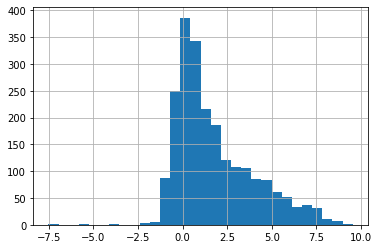

In [36]:
df_fakeB.query('D_mcErrors==512').B0_CMS3_weMissM2.hist(bins=30)
# df_fakeD.B0_CMS3_weMissM2.hist(bins=20)

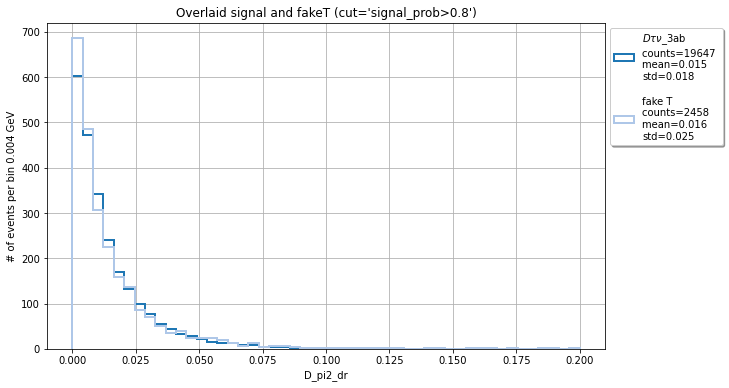

In [38]:
b1 = np.linspace(0,0.2,50)
plot_fakeB_overlaid(variable='D_pi2_dr',bins=b1,scale=[24/196,1],cut='signal_prob>0.8')

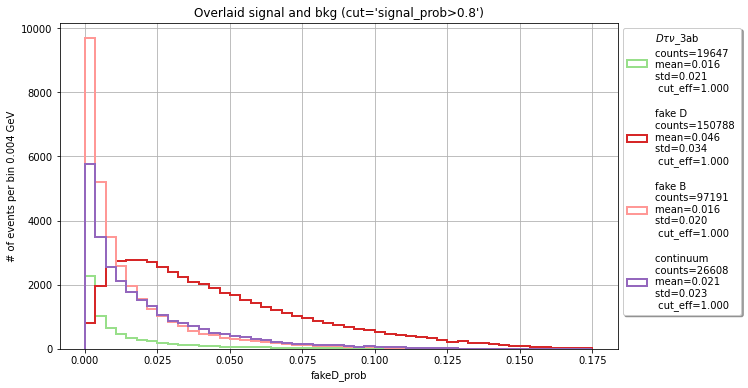

In [9]:
b1 = np.linspace(0,0.175,50)
plot_bkg_overlaid(variable='fakeD_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8')

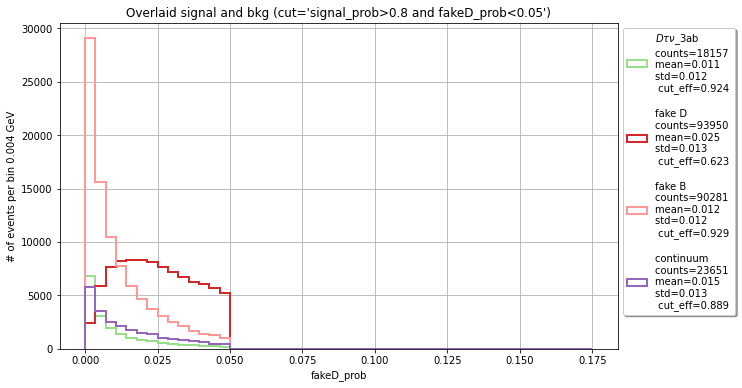

In [45]:
b1 = np.linspace(0,0.175,50)
plot_bkg_overlaid(variable='fakeD_prob',bins=b1,scale=[1,1,1,1],cut='signal_prob>0.8 and fakeD_prob<0.05')

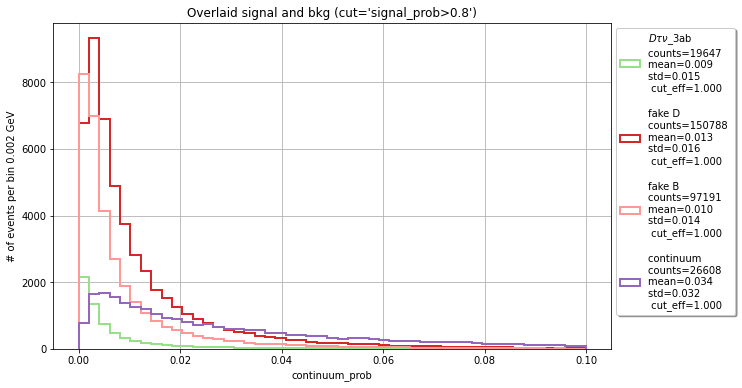

In [12]:
b1 = np.linspace(0,0.1,50)
plot_bkg_overlaid(variable='continuum_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8')

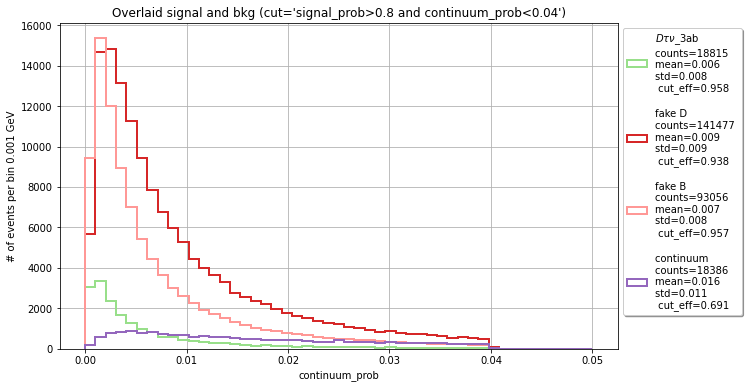

In [31]:
b1 = np.linspace(0,0.05,50)
plot_bkg_overlaid(variable='continuum_prob',bins=b1,scale=[1,1,1,1],cut='signal_prob>0.8 and continuum_prob<0.04')

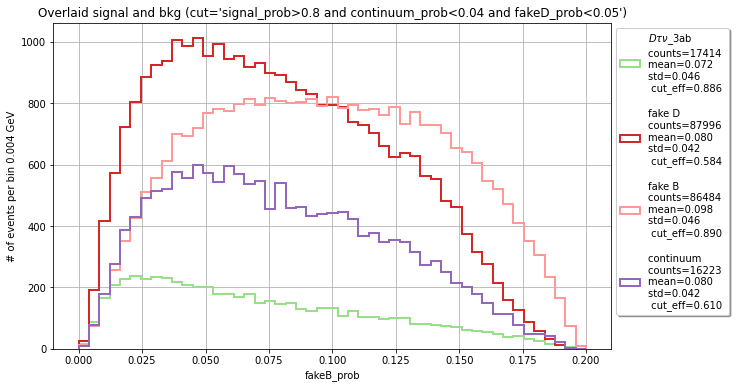

In [16]:
b1 = np.linspace(0,0.2,50)
plot_bkg_overlaid(variable='fakeB_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')

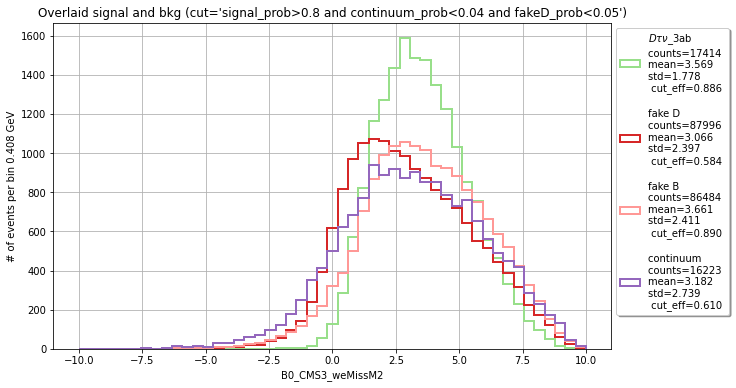

In [30]:
b1 = np.linspace(-10,10,50)
plot_bkg_overlaid(variable='B0_CMS3_weMissM2',bins=b1,scale=[1,16/87,16/86,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')

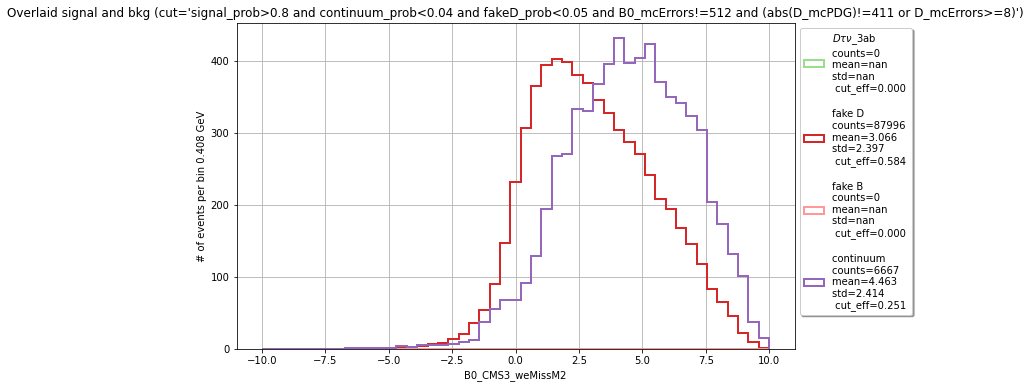

In [25]:
b1 = np.linspace(-10,10,50)
plot_bkg_overlaid(variable='B0_CMS3_weMissM2',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

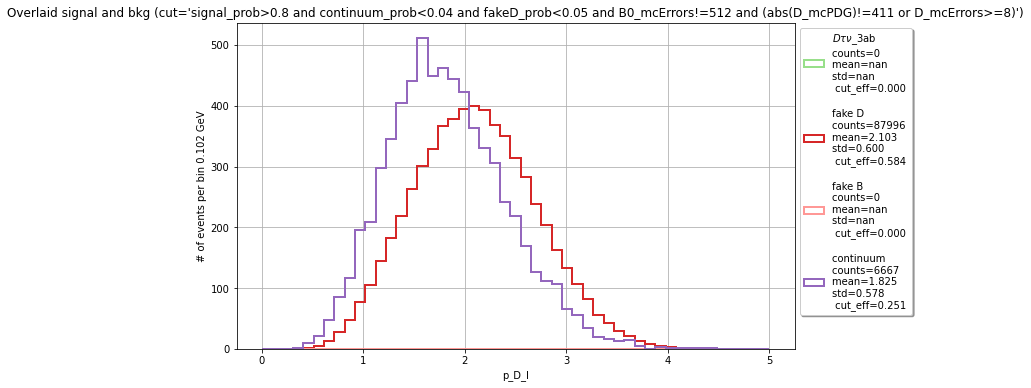

In [36]:
b1 = np.linspace(0,5,50)
plot_bkg_overlaid(variable='p_D_l',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

In [ ]:
b1 = np.linspace(0,5,50)
plot_bkg_overlaid(variable='p_D_l',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

In [18]:
df_fakeB.query('signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')['mode'].value_counts()

2    49041
3    35561
4     1882
Name: mode, dtype: int64

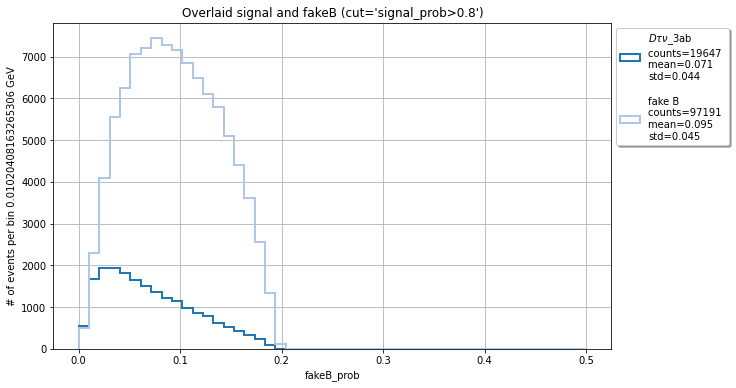

In [4]:
b1 = np.linspace(0,0.5,50)
plot_fakeB_overlaid(variable='fakeB_prob',bins=b1,scale=[1,1],cut='signal_prob>0.8') 

In [12]:
# apply the MVA cut
df_cut=df_lgb.query(cut)
df_bestSelected=df_cut.loc[df_cut.groupby(['__experiment__','__run__','__event__','__production__']).B_D_ReChi2.idxmin()]
df, samples=util.get_dataframe_samples(df_bestSelected, 'e', template=False)
# mpl=util.mpl(samples)
# ply=util.ply(df)
for name, df in samples.items():
    print(name, len(df))

$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D^{\ast\ast}\tau\nu$_mixed 0
$D^{\ast\ast}\tau\nu$_charged 0
$D\ell\nu$ 1
$D^\ast\ell\nu$ 1
res_$D^{\ast\ast}\ell\nu$_mixed 123
nonres_$D^{\ast\ast}\ell\nu$_mixed 26
gap_$D^{\ast\ast}\ell\nu$_mixed 44
res_$D^{\ast\ast}\ell\nu$_charged 0
nonres_$D^{\ast\ast}\ell\nu$_charged 0
bkg_fakeTC 0
bkg_continuum 0
bkg_fakeD 13
bkg_combinatorial 8
bkg_Odecay 2
bkg_others 0


In [18]:
# Assuming your DataFrame is named 'df'
# Use dtypes attribute to get the data types of each column
column_data_types = samples[r'$D\tau\nu$'].dtypes

# Filter the columns that have data type 'object' (strings)
columns_with_strings = column_data_types[column_data_types == 'object'].index.tolist()

# Now, columns_with_strings contains the names of columns with strings
print("Columns with strings:", columns_with_strings)


Columns with strings: []


In [19]:
samples[r'$D\tau\nu$']['mode']

104964     5
750160     5
77657      5
64582      5
737169     5
          ..
494521     5
1194341    5
728468     5
612497     5
1314525    5
Name: mode, Length: 2677, dtype: int64

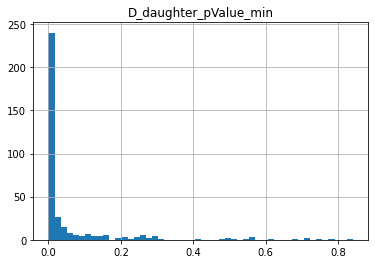

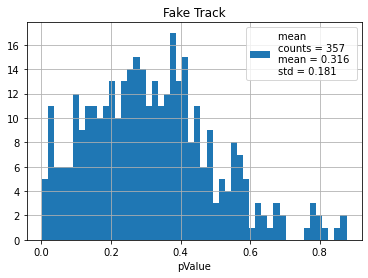

In [8]:
fakeK.hist(column='D_daughter_pValue_min',bins=50,label='min \n'+statistics(fakeK['D_daughter_pValue_min']))
fakeK.hist(column='D_daughter_pValue_mean',bins=50,label='mean \n'+statistics(fakeK['D_daughter_pValue_mean']))
plt.title('Fake Track')
#plt.xlim(-6,10)
plt.xlabel('pValue')
plt.legend()

In [8]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.


In [11]:
df_test8 = samples[r'bkg_others']#.query('D_K_mcErrors==512')
df_test8[['B0_mcErrors','B0_mcPDG','D_mcErrors','D_mcPDG','D_genMotherPDG','ell_genMotherPDG',
          'ell_mcErrors','ell_mcPDG','B0_mcDaughter_0_PDG','B0_mcDaughter_1_PDG',
          'D_K_pValue','D_pi1_pValue','D_pi2_pValue','B0_CMS3_weMissM2']]

,B0_mcErrors,B0_mcPDG,D_mcErrors,D_mcPDG,D_genMotherPDG,ell_genMotherPDG,ell_mcErrors,ell_mcPDG,B0_mcDaughter_0_PDG,B0_mcDaughter_1_PDG,D_K_pValue,D_pi1_pValue,D_pi2_pValue,B0_CMS3_weMissM2
9031149,1064.0,-511.0,0.0,411.0,-511.0,15.0,0.0,11.0,411.0,15.0,0.533852,0.139285,0.419654,4.124138


In [19]:
df_test8.D_pi2_pValue.describe()

count    3.570000e+02
mean     4.010878e-01
std      3.027756e-01
min      4.032672e-24
25%      1.329615e-01
50%      3.569602e-01
75%      6.510172e-01
max      9.997345e-01
Name: D_pi2_pValue, dtype: float64

In [34]:
df_test8.index

Int64Index([412, 1016, 1101, 1109, 1263, 1751], dtype='int64')

In [ ]:
test_p = [0,0.02,0.04,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.97,0.98]
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'], bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum'], variable='signal_prob', test_points=test_p, cut=None)

# 2. Plot

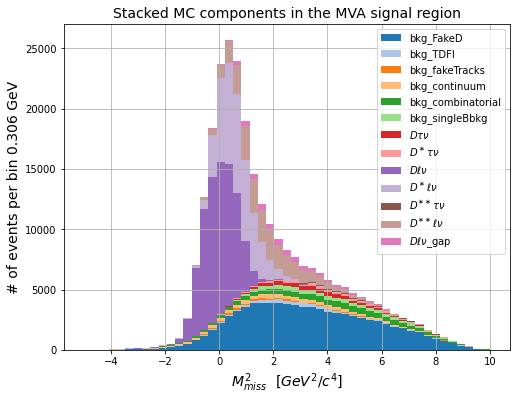

In [9]:
b1 = np.linspace(-5,10,50)
mpl.plot_all_stacked(variable='B0_CMS3_weMissM2',cut=None,bins=b1,
                      mask=[])
plt.title(r'Stacked MC components in the MVA signal region', fontsize=14);
plt.xlabel('$M^2_{miss} \ \ [GeV^2/c^4]$',fontsize=14);
# plt.ylabel('Density',fontsize=14);
plt.legend();

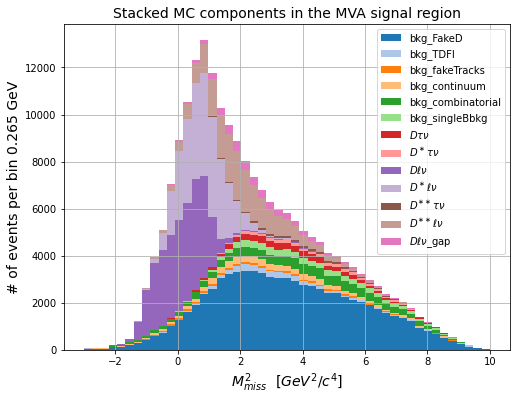

In [45]:
b1 = np.linspace(-3,10,50)
mpl.plot_all_stacked(variable='B0_CMS3_weMissM2',cut='p_D_l<3',bins=b1,
                      mask=[])
plt.title(r'Stacked MC components in the MVA signal region', fontsize=14);
plt.xlabel('$M^2_{miss} \ \ [GeV^2/c^4]$',fontsize=14);
# plt.ylabel('Density',fontsize=14);
plt.legend();

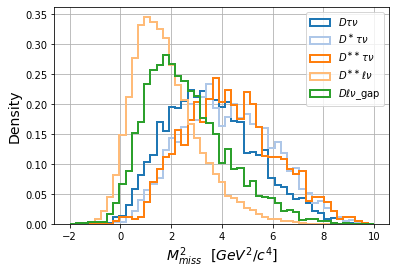

In [23]:
b1 = np.linspace(-2,10,50)
mpl.plot_all_overlaid(variable='B0_CMS3_weMissM2',cut=None,bins=b1,density=True,
                      mask=['bkg_FakeD','bkg_TDFl','bkg_fakeTracks',
                            'bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
                            #r'$D\tau\nu$', r'$D^\ast\tau\nu$', 
                            r'$D\ell\nu$',
                            r'$D^\ast\ell\nu$',#r'$D^{\ast\ast}\tau\nu$',
                            #r'$D^{\ast\ast}\ell\nu$',r'$D\ell\nu$_gap',])
                            ])
plt.title(r'');
plt.xlabel('$M^2_{miss} \ \ [GeV^2/c^4]$',fontsize=14);
plt.ylabel('Density',fontsize=14);
plt.legend()

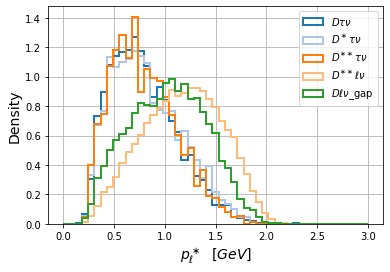

In [30]:
b1 = np.linspace(0,3,50)
mpl.plot_all_overlaid(variable='ell_CMS_p',cut=None,bins=b1,density=True,
                      mask=['bkg_FakeD','bkg_TDFl','bkg_fakeTracks',
                            'bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
                            #r'$D\tau\nu$', r'$D^\ast\tau\nu$', 
                            r'$D\ell\nu$',
                            r'$D^\ast\ell\nu$',#r'$D^{\ast\ast}\tau\nu$',
                            #r'$D^{\ast\ast}\ell\nu$',r'$D\ell\nu$_gap',
                           ])

plt.title(r'');
plt.xlabel(r'$p^\ast_{\ell} \ \ [GeV]$',fontsize=14);
plt.ylabel('Density',fontsize=14);
plt.legend()

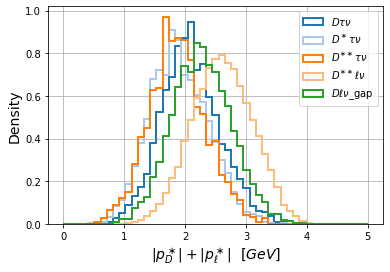

In [29]:
b1 = np.linspace(0,5,50)
mpl.plot_all_overlaid(variable='p_D_l',cut=None,bins=b1,density=True,
                      mask=['bkg_FakeD','bkg_TDFl','bkg_fakeTracks',
                            'bkg_continuum','bkg_combinatorial','bkg_singleBbkg',
                            #r'$D\tau\nu$', r'$D^\ast\tau\nu$', 
                            r'$D\ell\nu$',
                            r'$D^\ast\ell\nu$',#r'$D^{\ast\ast}\tau\nu$',
                            #r'$D^{\ast\ast}\ell\nu$',r'$D\ell\nu$_gap',
                           ])

plt.title(r'');
plt.xlabel(r'$|p^\ast_{D}| + |p^\ast_{\ell}| \ \ [GeV]$',fontsize=14);
plt.ylabel('Density',fontsize=14);
plt.legend()

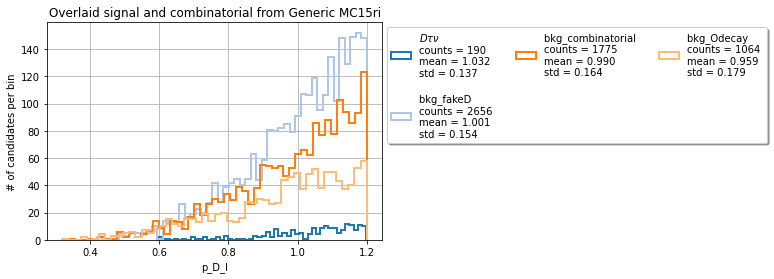

In [18]:
mpl.plot_all_overlaid(variable='p_D_l',cut='B0_CMS3_weMissM2>2.5 and cos_D_l>0.5 and p_D_l<1.2',
                      mask=['bkg_fakeTC','bkg_others',
                             r'$D^\ast\ell\nu$',r'$D^\ast\tau\nu$',
                            r'$D^{\ast\ast}\tau\nu$_mixed',
                            r'$D^{\ast\ast}\tau\nu$_charged',
                            r'res_$D^{\ast\ast}\ell\nu$_mixed',
                            r'nonres_$D^{\ast\ast}\ell\nu$_mixed',
                            r'gap_$D^{\ast\ast}\ell\nu$_mixed',
                            r'res_$D^{\ast\ast}\ell\nu$_charged',
                            r'nonres_$D^{\ast\ast}\ell\nu$_charged'])
# plt.xlabel('$|p^{CMS}_D| + |p^{CMS}_\ell| \ \ [GeV/c]$')
plt.title('Overlaid signal and combinatorial from Generic MC15ri');